In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pymc3 as pm
import arviz as az
import pandas as pd
import scipy.linalg as sp
import seaborn as sns
print('Running on PyMC3 v{}'.format(pm.__version__))
import theano
from sklearn.model_selection import train_test_split
import shelve
import warnings

%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')

Running on PyMC3 v3.9.3


In [2]:
#define function for nuts and advi trace plots
def nuts_advi(X, y, ofp, y_dist, opt, test_size=0.33):
    
    k = X.shape[1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    y_tensor = theano.shared(y_train.astype('float64'))
    X_tensor = theano.shared(X_train.astype('float64'))

    with pm.Model() as base_model:

        # Gumbel distribution 
        # Intercept term
        β0 = pm.Normal('β0', mu=0, sd=1e5)

        # Beta coefficients for predictor variables
        β = pm.MvNormal('β', mu=np.zeros(k), cov=np.eye(k), shape=k)

        # Calcuate mean from the normal variables, and add intercept
        mu = pm.math.dot(X_tensor,β) + β0
        beta = pm.HalfCauchy('beta', 1e5)

        # Pass the mu and beta with the observed data
        if y_dist == 'Gumbel':
            y_likelihood = pm.Gumbel('fMSE', mu=mu, beta=beta, observed=y_tensor)
        elif y_dist == 'Lognormal':
            y_likelihood = pm.Lognormal('fMSE', mu=mu, sigma=beta, observed=y_tensor)
        #start = pm.find_MAP()

    #pm.model_to_graphviz(base_model)
    
    if opt == 'nuts':
        with base_model:
        # Variational inference with ADVI optimization
            step       = pm.NUTS(target_accept=0.95)
            trace_nuts = pm.sample(draws=4000, step=step, tune=1000, cores=4)
            idata_nuts = az.from_pymc3(trace_nuts)

        filename = ofp + '_nuts.out'
        my_shelf = shelve.open(filename, 'n')
        my_shelf['base_model'] = base_model
        my_shelf['trace_nuts'] = trace_nuts
        my_shelf['idata_nuts'] = idata_nuts
        my_shelf['X_tensor']   = X_tensor
        my_shelf['y_tensor']   = y_tensor
        my_shelf['X_train']    = X_train
        my_shelf['y_train']    = y_train
        my_shelf['X_test']     = X_test
        my_shelf['y_test']     = y_test
        my_shelf.close()
        
    elif opt == 'advi':
        map_tensor_batch = {y_tensor: pm.Minibatch(y_train, 100), X_tensor: pm.Minibatch(X_train, 100)}
        
        with base_model:
             fit_advi= pm.fit(method=pm.ADVI(), n=300000, more_replacements = map_tensor_batch)
        
        trace_advi = fit_advi.sample(10000)
       
        filename = ofp + '_advi.out'
        my_shelf = shelve.open(filename, 'n')
        my_shelf['base_model'] = base_model
        my_shelf['fit_advi']   = fit_advi
        my_shelf['trace_advi'] = trace_advi
        my_shelf['X_tensor']   = X_tensor
        my_shelf['y_tensor']   = y_tensor
        my_shelf['X_train']    = X_train
        my_shelf['y_train']    = y_train
        my_shelf['X_test']     = X_test
        my_shelf['y_test']     = y_test
        my_shelf.close()

def shelf_read(filename):

    my_shelf = shelve.open(filename)
    for key in my_shelf:
        globals()[key]=my_shelf[key]
    my_shelf.close()

def trace_elbo_plot(trace_or_fit, opt):
    if opt == 'trace':
        pm.traceplot(trace_or_fit)
    elif opt == 'summary':
        pm.summary(trace_or_fit)
    elif opt =='elbo':
        elbo = pd.DataFrame(
            {'log-ELBO': -np.log(fit_advi.hist),
             'n': np.arange(fit_advi.hist.shape[0])})
        _ = sns.lineplot(y='log-ELBO', x='n', data=elbo)
    else:
        print('trace, summary, or elbo keywords should be given')
        
def model_RMSE(y_tensor, X_tensor, y_test, X_test, y_dist):
    y_tensor.set_value(y_test)
    X_tensor.set_value(X_test)
    k = X_test.shape[1]
    with pm.Model() as base_model:

            # Gumbel distribution 
            # Intercept term
            β0 = pm.Normal('β0', mu=0, sd=1e5)

            # Beta coefficients for predictor variables
            β = pm.MvNormal('β', mu=np.zeros(k), cov=np.eye(k), shape=k)

            # Calcuate mean from the normal variables, and add intercept
            mu = pm.math.dot(X_tensor,β) + β0
            beta = pm.HalfCauchy('beta', 1e5)

            # Pass the mu and beta with the observed data
            if y_dist == 'Gumbel':
                y_likelihood = pm.Gumbel('fMSE', mu=mu, beta=beta, observed=y_tensor)
            elif y_dist == 'Lognormal':
                y_likelihood = pm.Lognormal('fMSE', mu=mu, sigma=beta, observed=y_tensor)
            #start = pm.find_MAP()

    advi_posterior_pred = pm.fast_sample_posterior_predictive(trace_advi, model=base_model)
    advi_predictions = np.mean(advi_posterior_pred['fMSE'], axis=0)

    RMSE = np.sqrt(np.mean((advi_predictions - y_test) ** 2))
    
    return RMSE

def model_prediction(y_tensor, X_tensor, y_test, X_test, trace_nuts, trace_advi, dist):
    y_tensor.set_value(y_test)
    X_tensor.set_value(X_test)
    k = X_test.shape[1]

    with pm.Model() as base_model:

            # Gumbel distribution 
            # Intercept term
            β0 = pm.Normal('β0', mu=0, sd=1e5)

            # Beta coefficients for predictor variables
            β = pm.MvNormal('β', mu=np.zeros(k), cov=np.eye(k), shape=k)

            # Calcuate mean from the normal variables, and add intercept
            mu = pm.math.dot(X_tensor,β) + β0
            beta = pm.HalfCauchy('beta', 1e5)

            # Pass the mu and beta with the observed data
            if y_dist == 'Gumbel':
                y_likelihood = pm.Gumbel('fMSE', mu=mu, beta=beta, observed=y_tensor)
            elif y_dist == 'Lognormal':
                y_likelihood = pm.Lognormal('fMSE', mu=mu, sigma=beta, observed=y_tensor)

    nuts_posterior_pred = pm.fast_sample_posterior_predictive(trace_nuts, model=base_model)
    nuts_predictions = np.mean(nuts_posterior_pred['fMSE'], axis=0)
    advi_posterior_pred = pm.fast_sample_posterior_predictive(trace_advi, model=base_model)
    advi_predictions = np.mean(advi_posterior_pred['fMSE'], axis=0)
    
    prediction_data = pd.DataFrame(
          {'NUTS': nuts_predictions,
          'ADVI': advi_predictions,
          'actual': y_test,
          'error_ADVI': advi_predictions - y_test,
          'error_NUTS': nuts_predictions - y_test}
         )

    RMSE_ADVI = np.sqrt(np.mean(prediction_data.error_ADVI ** 2))
    RMSE_NUTS = np.sqrt(np.mean(prediction_data.error_NUTS ** 2))
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
    sns.regplot(y='ADVI', x='NUTS', data=prediction_data,
                   line_kws={'color': 'red', 'alpha': 0.5}, ax=ax1).set(title='ADVI vs NUTS', aspect=1)
    sns.regplot(y='ADVI', x='actual', data = prediction_data, 
                   line_kws={'color': 'red', 'alpha': 0.5}, ax=ax2).set(title='ADVI: '+f'{RMSE_ADVI:.3f}', aspect=1)
    sns.regplot(y='NUTS', x='actual', data = prediction_data,
                   line_kws={'color': 'red', 'alpha': 0.5}, ax=ax3).set(title='NUTS: '+f'{RMSE_NUTS: 3f}', aspect=1)
    
    return prediction_data, nuts_posterior_pred, advi_posterior_pred, base_model

In [21]:
# 1 load the data sets
pr_file   = "/home/hyung/Lab/data/DL_Error/predictors.csv"
res_file  = "/home/hyung/Lab/data/DL_Error/responses.csv"
pr_data   = pd.read_csv(pr_file)
res_data  = pd.read_csv(res_file)

# Rainf_f/Precip/SWdown_min have some issue because they are all zeros
pr_data.drop(columns=['Rainf_min', 'Rainf_f_min', 'Rainf_f_max','Rainf_f_tavg', 'TotalPrecip_min'], inplace=True)
pr_data.drop(columns=['Evap_min', 'Evap_max', 'Evap_tavg'], inplace=True)
pr_data.drop(columns=['LWdown_f_max', 'LWdown_f_min', 'LWdown_f_tavg'], inplace=True)
pr_data.drop(columns=['Qair_f_max',	'Qair_f_min', 'Qh_max',	'Qh_min'], inplace=True)
pr_data.drop(columns=['Qle_min', 'Qle_max', 'Qle_tavg'], inplace=True)
pr_data.drop(columns=['SWdown_f_min', 'SWdown_f_max', 'SWdown_f_tavg'], inplace=True)
pr_data.drop(columns=['SMOS_RFI_min', 'SoilMoist_max', 'SoilMoist_min',	'SoilMoist_tavg'], inplace=True)
pr_data.drop(columns=['Tair_f_max', 'Tair_f_min', 'Tair_f_tavg', 'aspect'], inplace=True)
pr_data.drop(columns=['Wind_f_max',	'Wind_f_min', 'Wind_f_tavg'], inplace=True)
pr_data.drop(columns=['LAI_min', 'LAI_max','Greenness_min', 'Greenness_max', 'AvgSurfT_min', 'AvgSurfT_max'],inplace=True)
pr_data.drop(columns=['SoilTemp_min', 'SoilTemp_max','RadT_min', 'RadT_max'],inplace=True)
pr_data.drop(columns=['SMAP_vo_min', 'SMAP_vo_max','SMAP_rc_min', 'SMAP_rc_max'],inplace=True)
pr_data.drop(columns=['albedo_max', 'albedo_min','albedo_std', 'TotalPrecip_max','Rainf_max','SMOS_RFI_max'],inplace=True)

#Group the data using RFI values
nog = 5
RFI_tavg = pr_data['SMOS_RFI_tavg'].dropna(axis=0, how='any')
RFI_p = np.empty(nog, dtype=object)
for i in range(1,nog+1):
    RFI_p[i-1] = np.percentile(RFI_tavg, i*100/nog)

RFI_class = np.copy(pr_data['SMOS_RFI_tavg'])

for i in range(0,nog):
    if i > 0:
        RFI_class[(pr_data['SMOS_RFI_tavg'] > RFI_p[i-1]) & (pr_data['SMOS_RFI_tavg'] <= RFI_p[i])]=i
    elif i == 0:
        RFI_class[(pr_data['SMOS_RFI_tavg'] <= RFI_p[i])]=i
pr_data['RFI_class'] = RFI_class

# TC estimations with std value larger than 0.2 might be unstable
std_thred     = 0.1
mask_std_A2   = (res_data['AMSR2_std'] <= std_thred) & (pr_data.ltype!=21) & (pr_data.ltype!=17)
mask_std_AS   = (res_data['ASCAT_std'] <= std_thred) & (pr_data.ltype!=21) & (pr_data.ltype!=17)
mask_std_SMOS = (res_data['SMOS_std'] <= std_thred) & (pr_data.ltype!=21) & (pr_data.ltype!=17)
mask_std_SMAP = (res_data['SMAP_std'] <= std_thred) & (pr_data.ltype!=21) & (pr_data.ltype!=17)

# 2 clean the data sets
selected_predictors = list(pr_data.columns.values)

sel_A2   = selected_predictors.copy()
sel_A2.append('AMSR2_fMSE')
sel_AS   = selected_predictors.copy()
sel_AS.append('ASCAT_fMSE')
sel_SMOS = selected_predictors.copy()
sel_SMOS.append('SMOS_fMSE')
sel_SMAP = selected_predictors.copy()
sel_SMAP.append('SMAP_fMSE')

A2_fMSE   = pr_data.join(res_data['AMSR2_fMSE'])[sel_A2]
AS_fMSE   = pr_data.join(res_data['ASCAT_fMSE'])[sel_AS]
SMOS_fMSE = pr_data.join(res_data['SMOS_fMSE'])[sel_SMOS]
SMAP_fMSE = pr_data.join(res_data['SMAP_fMSE'])[sel_SMAP]

# select fMSE <= threshold
A2_fMSE   = A2_fMSE[mask_std_A2]
AS_fMSE   = AS_fMSE[mask_std_AS]
SMOS_fMSE = SMOS_fMSE[mask_std_SMOS]
SMAP_fMSE = SMAP_fMSE[mask_std_SMAP]
                      
# drop N/A
A2_fMSE.dropna(axis=0, how='any', inplace=True)
AS_fMSE.dropna(axis=0, how='any', inplace=True)
SMOS_fMSE.dropna(axis=0, how='any', inplace=True)
SMAP_fMSE.dropna(axis=0, how='any', inplace=True)

# Numeric, categorical predictors and response, y`
# AMSR2
A2_num   = A2_fMSE.drop(columns=['ltype', 'RFI_class', 'SMOS_RFI_tavg', 'AMSR2_fMSE'])
A2_cat   = A2_fMSE['ltype']
A2_RFI   = A2_fMSE['RFI_class']
A2_y     = A2_fMSE['AMSR2_fMSE']
# ASCAT
AS_num   = AS_fMSE.drop(columns=['ltype', 'RFI_class', 'SMOS_RFI_tavg', 'ASCAT_fMSE'])
AS_cat   = AS_fMSE['ltype']
AS_RFI   = AS_fMSE['RFI_class']
AS_y     = AS_fMSE['ASCAT_fMSE']
# SMOS
SMOS_num = SMOS_fMSE.drop(columns=['ltype', 'RFI_class', 'SMOS_RFI_tavg', 'SMOS_fMSE'])
SMOS_cat = SMOS_fMSE['ltype']
SMOS_RFI = SMOS_fMSE['RFI_class']
SMOS_y   = SMOS_fMSE['SMOS_fMSE']
# SMAP
SMAP_num = SMAP_fMSE.drop(columns=['ltype', 'RFI_class', 'SMOS_RFI_tavg', 'SMAP_fMSE'])
SMAP_cat = SMAP_fMSE['ltype']
SMAP_RFI = SMAP_fMSE['RFI_class']
SMAP_y   = SMAP_fMSE['SMAP_fMSE']

all_predictors = SMAP_num.columns.values

# Standardize numeric/response columns, to mean 0 variance 1
# AMSR2
A2_mean       = A2_num.mean()
A2_std        = A2_num.std()
A2_num_scaled = np.array((A2_num - A2_mean) / A2_std)
A2_y_mean     = A2_y.mean()
A2_y_std      = A2_y.std()
A2_y_scaled   = np.array((A2_y - A2_y_mean) / A2_y_std)
# ASCAT
AS_mean       = AS_num.mean()
AS_std        = AS_num.std()
AS_num_scaled = np.array((AS_num - AS_mean) / AS_std)
AS_y_mean     = AS_y.mean()
AS_y_std      = AS_y.std()
AS_y_scaled   = np.array((AS_y - AS_y_mean) / AS_y_std)
# SMOS
SMOS_mean       = SMOS_num.mean()
SMOS_std        = SMOS_num.std()
SMOS_num_scaled = np.array((SMOS_num - SMOS_mean) / SMOS_std)
SMOS_y_mean     = SMOS_y.mean()
SMOS_y_std      = SMOS_y.std()
SMOS_y_scaled   = np.array((SMOS_y - SMOS_y_mean) / SMOS_y_std)
# SMAP
SMAP_mean        = SMAP_num.mean()
SMAP_std         = SMAP_num.std()
SMAP_num_scaled  = np.array((SMAP_num - SMAP_mean) / SMAP_std)
SMAP_y_mean      = SMAP_y.mean()
SMAP_y_std       = SMAP_y.std()
SMAP_y_scaled    = np.array((SMAP_y - SMAP_y_mean) / SMAP_y_std)

In [22]:
Rclasses_SMAP = SMAP_fMSE['RFI_class'].unique()
nRclasses_SMAP = len(Rclasses_SMAP)
Rclass_lookup = dict(zip(Rclasses_SMAP, range(nRclasses_SMAP)))
Rclass_SMAP = SMAP_fMSE['Rclass_code'] = SMAP_fMSE.RFI_class.replace(Rclass_lookup).values.astype('int')

In [23]:
X_input = np.hstack((SMAP_num_scaled, SMAP_RFI.values.reshape(-1,1)))
y_input = SMAP_y

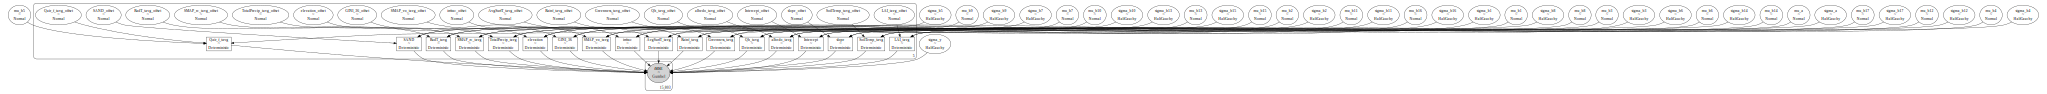

In [27]:
with pm.Model() as hi_model:
    nRclasses = nRclasses_SMAP
    X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.50, stratify=Rclass_SMAP, random_state=42)
    Rclass_train = X_train[:,-1].astype('int')
    Rclass_test  = X_test[:,-1].astype('int')
    X_train  = X_train[:,:-1]
    X_test   = X_test[:,:-1]
    
    X        = X_train
    y        = y_train
    Rclass   = Rclass_train
    nop      = X_train.shape[1]

    # Priors for the model paramters
    # Gaussians for the means of the priors of the random intercpets and slopes
    mu_a = pm.Normal('mu_a', mu=0, sd=1e5)
    for i in range(1,nop+1):
        exec('mu_b'+str(i)+'=pm.Normal(\'mu_b'+str(i)+'\', mu=0, sd=1e5)')
    
    # Half-Cauchy for the standard deviation of the priros of the random intercpets and slops
    sigma_a  = pm.HalfCauchy('sigma_a', 1e5)
    for i in range(1,nop+1):
        exec('sigma_b'+str(i)+'=pm.HalfCauchy(\'sigma_b'+str(i)+'\', beta=1e5)')
  
    # Gaussian priors for random intercpets and slopes
    a_offset = pm.Normal('Intercept_offset', mu=0, sd=1, shape=nRclasses)
    a  = pm.Deterministic('Intercept', mu_a + a_offset*sigma_a)
    for i in range(1,nop+1):
        exec('b'+str(i)+'_offset = pm.Normal(\''+all_predictors[i-1]+'_offset\', mu=0, sd=1, shape=nRclasses)')
        exec('b'+str(i)+'=pm.Deterministic(all_predictors[i-1], mu_b'+str(i)+'+b'+str(i)+'_offset*sigma_b'+str(i)+')')
        
             
    # Linear model
    mu_init = 'mu = a[Rclass]'
    for i in range(1,nop+1):
        mu_init = mu_init+'+b'+str(i)+'[Rclass]*X[:,'+str(i-1)+']'
    exec(mu_init)

    # Model errors
    beta = pm.HalfCauchy('sigma_y', 1e5)
    
    # Data likelihood
    y_hat =  pm.Gumbel('fMSE', mu = mu, beta = beta, observed = y)

pm.model_to_graphviz(hi_model)

Sequential sampling (2 chains in 1 job)
NUTS: [sigma_y, slope_offset, irrfrac_offset, elevation_offset, albedo_tavg_offset, TotalPrecip_tavg_offset, SoilTemp_tavg_offset, SMAP_vo_tavg_offset, SMAP_rc_tavg_offset, SAND_offset, Rainf_tavg_offset, RadT_tavg_offset, Qh_tavg_offset, Qair_f_tavg_offset, LAI_tavg_offset, Greenness_tavg_offset, GINI_36_offset, AvgSurfT_tavg_offset, Intercept_offset, sigma_b17, sigma_b16, sigma_b15, sigma_b14, sigma_b13, sigma_b12, sigma_b11, sigma_b10, sigma_b9, sigma_b8, sigma_b7, sigma_b6, sigma_b5, sigma_b4, sigma_b3, sigma_b2, sigma_b1, sigma_a, mu_b17, mu_b16, mu_b15, mu_b14, mu_b13, mu_b12, mu_b11, mu_b10, mu_b9, mu_b8, mu_b7, mu_b6, mu_b5, mu_b4, mu_b3, mu_b2, mu_b1, mu_a]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 40016 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


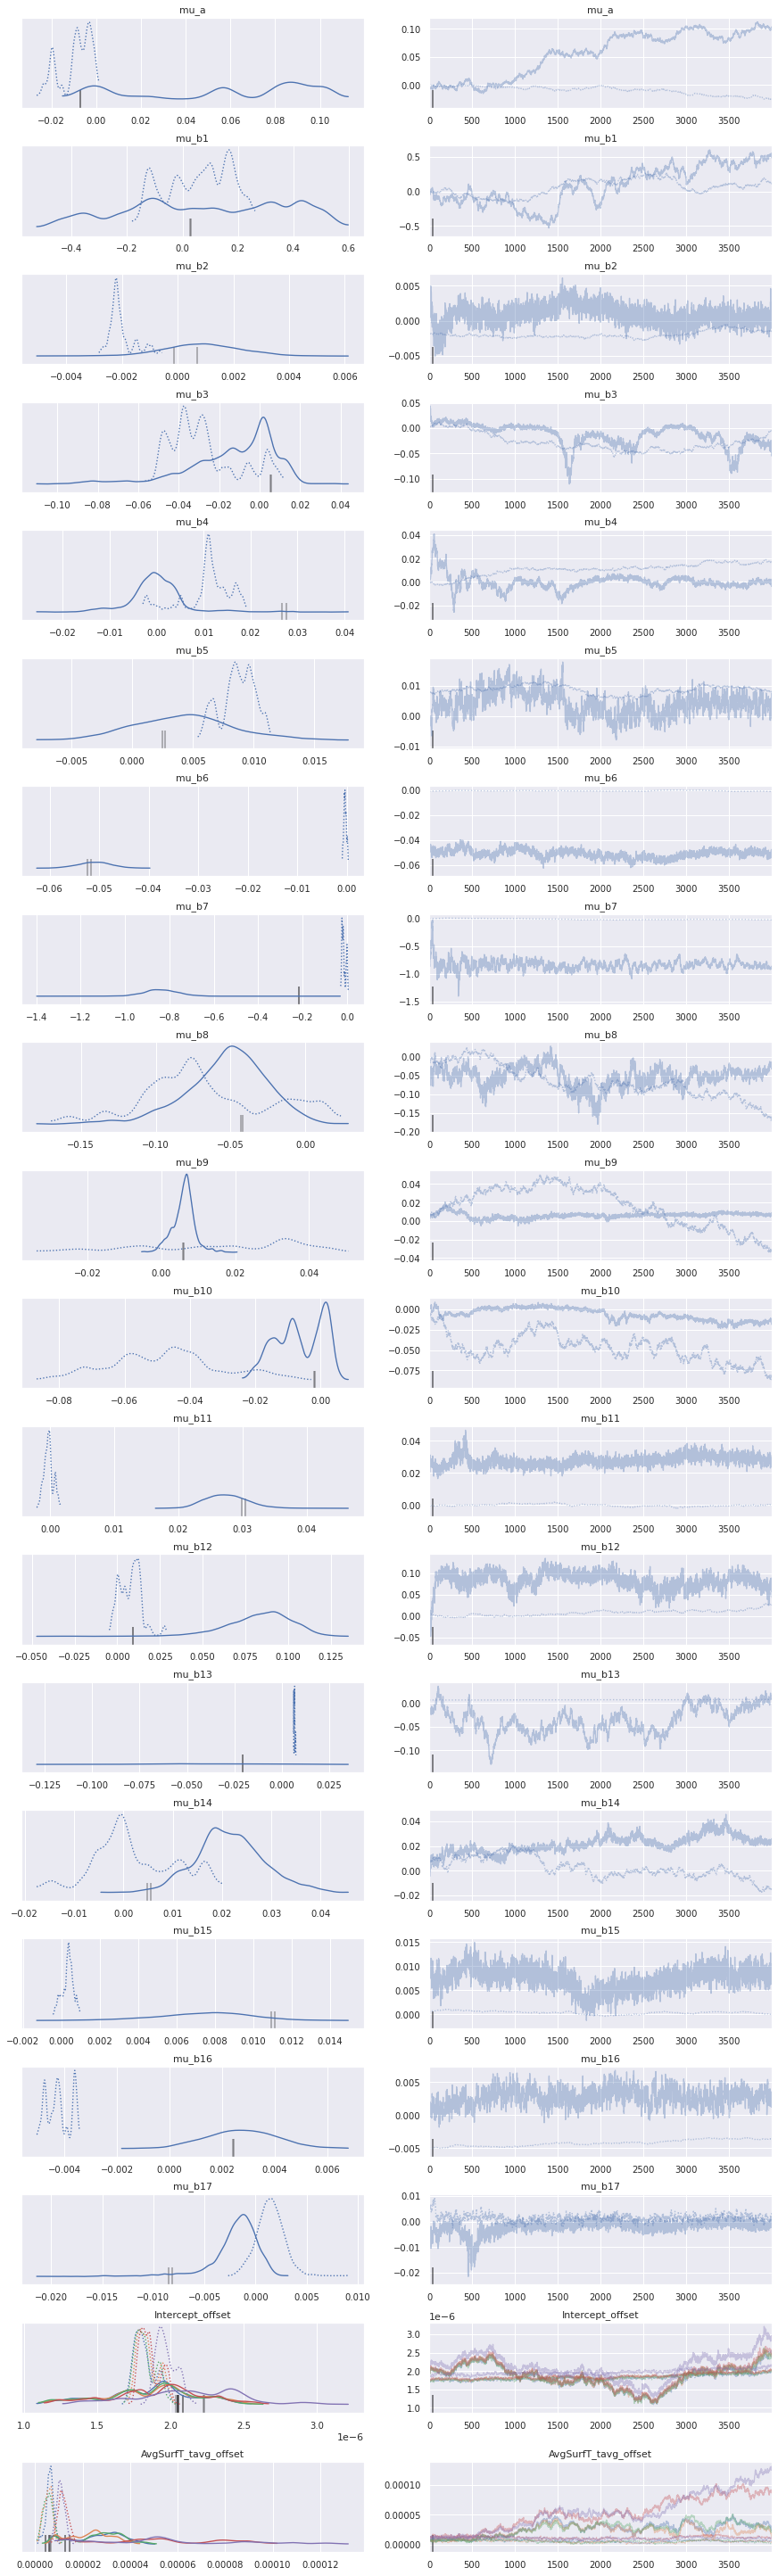

In [28]:
with hi_model:
    #map_estimate = pm.find_MAP()
    trace_hi_nuts = pm.sample(4000, step = pm.NUTS(target_accept = 0.99), tune=1000, cores=1)
    #idata_hi_nuts= az.from_pymc3(trace_hi_nuts) 
with hi_model:
     pm.traceplot(trace_hi_nuts)

In [187]:
#map_tensor_batch = {y: pm.Minibatch(y, 100), X: pm.Minibatch(X, 100)}
        
with hi_model:
    fit_advi= pm.fit(method=pm.ADVI(), n=200000)
    trace_advi = fit_advi.sample(10000)

Interrupted at 31,637 [15%]: Average Loss = 1.6616e+05


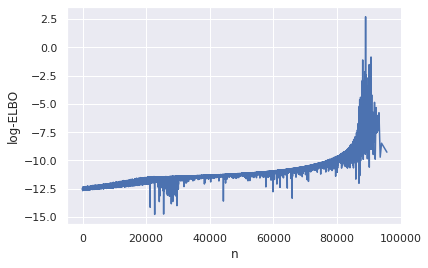

In [181]:
import numpy as np
elbo = pd.DataFrame({'log-ELBO': -np.log(fit_advi.hist), 'n': np.arange(fit_advi.hist.shape[0])})
_ = sns.lineplot(y='log-ELBO', x='n', data=elbo)

In [ ]:
ofp = '/home/hyung/Lab/libs/python/DL_Error_data/SMAP_ywos_hi' 
filename = ofp + '_nuts.out'
myshelf = shelve.open(filename, 'n')
myshelf['hi_model'] = hi_model
myshelf['trace_hi_nuts'] = trace_hi_nuts
myshelf['idata_hi_nuts'] = idata_hi_nuts

In [ ]:
shelf_read(ofp+'nuts')

In [ ]:
# run VI and Sampling (y with scaling)
dist = 'Gumbel'
test_size = 0.33
ofp = '/home/hyung/Lab/libs/python/DL_Error_data/A2' 
nuts_advi(A2_num_scaled, A2_y_scaled, ofp, dist, 'advi', test_size)
nuts_advi(A2_num_scaled, A2_y_scaled, ofp, dist, 'nuts', test_size)

ofp = '/home/hyung/Lab/libs/python/DL_Error_data/AS' 
nuts_advi(AS_num_scaled, AS_y_scaled, ofp, dist, 'advi', test_size)
nuts_advi(AS_num_scaled, AS_y_scaled, ofp, dist, 'nuts', test_size)

ofp = '/home/hyung/Lab/libs/python/DL_Error_data/SMOS' 
nuts_advi(SMOS_num_scaled, SMOS_y_scaled, ofp, dist, 'advi', test_size)
nuts_advi(SMOS_num_scaled, SMOS_y_scaled, ofp, dist, 'nuts', test_size)

ofp = '/home/hyung/Lab/libs/python/DL_Error_data/SMAP' 
nuts_advi(SMAP_num_scaled, SMAP_y_scaled, ofp, dist, 'advi', test_size)
nuts_advi(SMAP_num_scaled, SMAP_y_scaled, ofp, dist, 'nuts', test_size)

In [ ]:
# run VI and Sampling (y without scaling)
dist = 'Gumbel'
test_size = 0.33
ofp = '/home/hyung/Lab/libs/python/DL_Error_data/A2_ywos' 
nuts_advi(A2_num_scaled, A2_y.values, ofp, dist, 'advi', test_size)
nuts_advi(A2_num_scaled, A2_y.values, ofp, dist, 'nuts', test_size)

ofp = '/home/hyung/Lab/libs/python/DL_Error_data/AS_ywos' 
nuts_advi(AS_num_scaled, AS_y.values, ofp, dist, 'advi', test_size)
nuts_advi(AS_num_scaled, AS_y.values, ofp, dist, 'nuts', test_size)

ofp = '/home/hyung/Lab/libs/python/DL_Error_data/SMOS_ywos' 
nuts_advi(SMOS_num_scaled, SMOS_y.values, ofp, dist, 'advi', test_size)
nuts_advi(SMOS_num_scaled, SMOS_y.values, ofp, dist, 'nuts', test_size)

ofp = '/home/hyung/Lab/libs/python/DL_Error_data/SMAP_ywos' 
nuts_advi(SMAP_num_scaled, SMAP_y.values, ofp, dist, 'advi', test_size)
nuts_advi(SMAP_num_scaled, SMAP_y.values, ofp, dist, 'nuts', test_size)

In [ ]:
# Check hdi 3% and 97%
filename = '/home/hyung/Lab/libs/python/DL_Error_data/SMAP_ywos_nuts.out'    
shelf_read(filename)
summary_nuts = pm.summary(trace_nuts)
hdi_3  = summary_nuts['hdi_3%'][1:-1]
hdi_97 = summary_nuts['hdi_97%'][1:-1]
invalid_p_i = np.where((hdi_3 < 0) & (hdi_97 > 0))
valid_p_i   = np.where(~((hdi_3 <0) & (hdi_97 > 0)))

In [ ]:
# Run model with selected variables

top_sel = 10
top_sel_i = np.argsort(np.abs(summary_nuts['mean'][1:-1].values[valid_p_i])) < top_sel
top_sel_i = valid_p_i[0][top_sel_i]SMAP_num_scaled_sel = np.squeeze(SMAP_num_scaled[:,valid_p_i])
SMAP_num_scaled_sel = np.squeeze(SMAP_num_scaled[:,valid_p_i])
SMAP_num_scaled_topsel = np.squeeze(SMAP_num_scaled[:,top_sel_i])

# It does not chage much
ofp = '/home/hyung/Lab/libs/python/DL_Error_data/SMAP_ywos_topsel' 
nuts_advi(SMAP_num_scaled_topsel, SMAP_y.values, ofp, dist, 'advi', 0.7)
#nuts_advi(SMAP_num_scaled_sel, SMAP_y.values, ofp, dist, 'nuts', 0.7)

In [ ]:
filename = '/home/hyung/Lab/libs/python/DL_Error_data/SMAP_ywos_topsel_advi.out'    
shelf_read(filename)
RMSE = model_RMSE(y_tensor, X_tensor, y_test, X_test, y_dist)
print(f'RMSE for the predictions = {RMSE:.3f}')

In [ ]:
summary_nuts['mean'][1:-1].values[top_sel_i]

In [ ]:
all_predictors[top_sel_i]

In [ ]:
plt.hist((trace_nuts['β'][:,top_sel_i[0]]), 50)

In [ ]:
filename = '/home/hyung/Lab/libs/python/DL_Error_data/SMOS_ywos_nuts.out'    
shelf_read(filename)
filename = '/home/hyung/Lab/libs/python/DL_Error_data/SMOS_ywos_advi.out'    
shelf_read(filename)
summary_nuts = pm.summary(trace_nuts)
hdi_3  = summary_nuts['hdi_3%'][1:-1]
hdi_97 = summary_nuts['hdi_97%'][1:-1]
invalid_p_i = np.where((hdi_3 < 0) & (hdi_97 > 0))
all_predictors[invalid_p_i]

In [ ]:
dist = 'Gumbel'
RMSE = model_RMSE(y_tensor, X_tensor, y_test, X_test, dist)
print(f'RMSE for the predictions = {RMSE:.3f}')

In [ ]:
prediction_data, nuts_posterior_pred, advi_posterior_pred, base_model = model_prediction(y_tensor, X_tensor, y_test, X_test, trace_nuts, trace_advi, dist)

In [ ]:
ppc_data = az.from_pymc3(posterior_predictive=nuts_posterior_pred, model=base_model)
ax = az.plot_ppc(data=ppc_data, color="C5")
ax.set_xlim(0,1)
ax.set_ylabel('PDF')
ax.set_ylim(0, 5)

In [ ]:
az.plot_forest(trace_nuts, var_names=['β'], combined=True,
               kind='ridgeplot', ridgeplot_quantiles=[0.16, 0.5, 0.84],
               ridgeplot_truncate=False, hdi_prob=0.95,
               ridgeplot_overlap=3, ridgeplot_alpha=0.5)

In [ ]:
ppc_data = az.from_pymc3(posterior_predictive=nuts_posterior_pred, model=base_model)

In [ ]:
ax = az.plot_ppc(data=ppc_data)
ax.set_xlim(0,1)
ax.set_ylabel('PDF')
ax.set_ylim(0, 5)

In [ ]:
az.plot_ppc(az.from_pymc3(posterior_predictive=advi_posterior_pred, model=base_model))

In [ ]:
param_samples_NUTS = pd.DataFrame(
    {'β0': trace_sampling.get_values('β0')[:, ], 
     'β': trace_sampling.get_values('β')[:, 0]})

_ = sns.scatterplot(x='β0', y='β', data=param_samples_NUTS).set_title('NUTS')

In [ ]:
param_samples_ADVI = pd.DataFrame(
    {'β0': advi_trace.get_values('β0')[:, ], 
     'β': advi_trace.get_values('β')[:, 0]})

_ = sns.scatterplot(x='β0', y='β', data=param_samples_ADVI).set_title('ADVI')

In [ ]:
PPC_SAMPLES = 20000
advi_trace  = advi_fit.sample(PPC_SAMPLES)

# Forest Plots to show the distributions for each of the predictors
#with advi_model:
az.plot_forest(advi_trace, var_names=['β'], combined=True,
               kind='ridgeplot', ridgeplot_quantiles=[0.16, 0.5, 0.84],
               ridgeplot_truncate=False, hdi_prob=0.95,
               ridgeplot_overlap=3, ridgeplot_alpha=0.5)

with base_model:
    idata_advi = az.from_pymc3(advi_trace)
az.summary(idata_advi, round_to=4, var_names = ['β'])

In [ ]:
all_predictors

In [ ]:
np.where(all_predictors == 'RadT_max')

In [ ]:
burnin = 100
sample_intercept = test_trace['β0'][burnin:]
sample_betas = test_trace['β'][burnin:]
advi_intercept = advi_trace_test['β0']
advi_betas = advi_trace_test['β']

# Plot posteriors

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 4), dpi=150, constrained_layout=False)

for ax, estimate_sampling, estimate_advi in zip(axes.ravel(),
                               [sample_intercept] + [sample_betas[:,i] for i in range(k)],
                               [advi_intercept] + [advi_betas[:,i] for i in range(k)]):
    
    pm.plot_posterior(estimate_sampling, ax=ax,point_estimate=None,  alpha=0.7)
    pm.plot_posterior(estimate_advi, ax=ax, color='red', point_estimate=None, hdi_prob= 'hide', alpha=0.7)
    
    #ax.set_title(title, fontsize=12)

    #ax.set_xlabel(xlabel, fontsize=12)

plt.suptitle("Regression parameters\nHMC sampling in blue\nVariational inference in red")
plt.tight_layout()
plt.subplots_adjust(top=0.75)
plt.show()

In [ ]:
all_predictors[37]